In [112]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [99]:
plt.style.use('ggplot')

In [2]:
driver = webdriver.Chrome(executable_path='/home/chewzy/selenium_drivers/chromedriver')

In [3]:
driver.get('https://services2.hdb.gov.sg/webapp/BP13BTOENQWeb/AR_May2021_SBF?strSystem=SBF')

In [4]:
soup = BeautifulSoup(driver.page_source)

In [21]:
table_2room, table_3room_abv = soup.find_all('table', class_='scrolltable')

In [23]:
table = table_3room_abv

In [24]:
df = pd.read_html(str(table))[0]
df.columns = ['town', 'flat_type', 'num_units', 'num_applicants',
              'first_timers', 'second_timers', 'overall']

In [25]:
df['flat_type'] = df['flat_type'].str.title()

In [26]:
sel = df['town'].isin(['Non-Mature Towns/Estates','Mature Towns/Estates','TOTAL'])

df = df.loc[~sel].copy()

In [27]:
for col in ['num_units', 'num_applicants']:
    df[col] = df[col].astype(int)

In [28]:
for col in ['first_timers', 'second_timers', 'overall']:
    df[col] = df[col].astype(float)

In [76]:
df['num_first_timers'] = (df['first_timers'] * df['num_units'] * 0.95).round().astype(int)

In [77]:
sel = df['second_timers'].notna()

df.loc[sel, 'num_second_timers'] = (
    (df.loc[sel, 'second_timers'] * df.loc[sel, 'num_units'] * 0.05)
    .round()
    .astype(int)
)

In [78]:
df['num_applicants_computed'] = df['num_first_timers'] + df['num_second_timers'].fillna(0)

<AxesSubplot:ylabel='Frequency'>

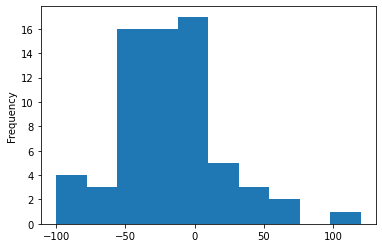

In [79]:
(df['num_applicants_computed'] - df['num_applicants']).plot(kind='hist')

In [89]:
df['flat_type'].value_counts()

4-Room                             24
3-Room                             11
3-Room (Income Ceiling $7,000)     10
5-Room / 3Gen                       7
5-Room                              6
5-Room / Executive                  4
5-Room / 3Gen / Executive           4
3-Room (Income Ceiling $14,000)     1
Name: flat_type, dtype: int64

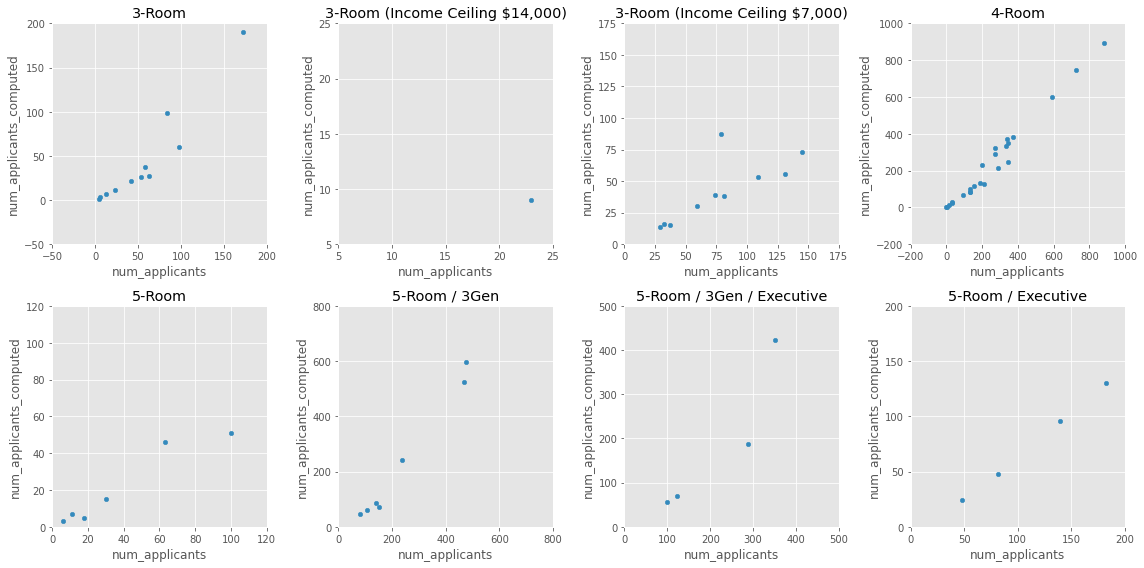

In [149]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))

ax = ax.ravel()

for i, flat_type in enumerate(sorted(df['flat_type'].unique())):

    sel = df['flat_type'] == flat_type
    (
        df
        .loc[sel]
        .plot(x='num_applicants', y='num_applicants_computed', kind='scatter',
              ax=ax[i], title=flat_type)
    )
    ymin, ymax = ax[i].get_ylim()
    xmin, xmax = ax[i].get_xlim()
    
    coord_min = min(xmin, ymin)
    coord_max = max(xmax, ymax)
        
    ax[i].set_xlim(coord_min, coord_max)
    ax[i].set_ylim(coord_min, coord_max)
    
    ticks = ax[i].get_xticks()
    ax[i].set_xticks(ticks)
    ax[i].set_yticks(ticks)
    
plt.tight_layout()

In [151]:
df.to_csv('../data/SBF_application_status_0528_1255.csv', index=False)